## Import Dependencies

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import string

import nltk
from nltk.stem.porter import *

from sklearn.model_selection import  train_test_split, GridSearchCV
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score

from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Dataset

In [2]:
data = pd.read_csv("./dataset/sentiment.tsv", sep="\t")
data.head()

,sentiment,text
0,neg,"@jamielewislewis i cant believe it, it really ..."
1,neg,Had a dream about a walk in fast food resturau...
2,neg,hates @internet @explrer (angry)(angry) **but ...
3,neg,@federalcase I said I go out for eat 5:negneg...
4,neg,@babykates7 yeah they won't do the surgery til...


Rename the columns to have a better understanding in the code.

In [3]:
data.columns = ['label', 'body_text']
data.head()

,label,body_text
0,neg,"@jamielewislewis i cant believe it, it really ..."
1,neg,Had a dream about a walk in fast food resturau...
2,neg,hates @internet @explrer (angry)(angry) **but ...
3,neg,@federalcase I said I go out for eat 5:negneg...
4,neg,@babykates7 yeah they won't do the surgery til...


In [4]:
le = LabelEncoder()
data['label'] = le.fit_transform(data['label'])
data.head()

,label,body_text
0,0,"@jamielewislewis i cant believe it, it really ..."
1,0,Had a dream about a walk in fast food resturau...
2,0,hates @internet @explrer (angry)(angry) **but ...
3,0,@federalcase I said I go out for eat 5:negneg...
4,0,@babykates7 yeah they won't do the surgery til...


## Cleaning Data

#### Remove @user

In [5]:
def remove_pattern(in_text, pattern):
    r = re.findall(pattern, in_text)
    for i in r:
        in_text = re.sub(i, '', in_text)
    return in_text

In [6]:
vec_rp = np.vectorize(remove_pattern)
data['tidy_text'] = vec_rp(data['body_text'], '@[\w]*')
data.head()

,label,body_text,tidy_text
0,0,"@jamielewislewis i cant believe it, it really ...","i cant believe it, it really doesnt belong th..."
1,0,Had a dream about a walk in fast food resturau...,Had a dream about a walk in fast food resturau...
2,0,hates @internet @explrer (angry)(angry) **but ...,hates (angry)(angry) **but no choice** http...
3,0,@federalcase I said I go out for eat 5:negneg...,I said I go out for eat 5:negneg p.m. I dis...
4,0,@babykates7 yeah they won't do the surgery til...,yeah they won't do the surgery till the cold ...


#### Remove special characters

In [7]:
data['tidy_text'] = data['tidy_text'].str.replace('[^a-zA-z#]', ' ')
data.head()

,label,body_text,tidy_text
0,0,"@jamielewislewis i cant believe it, it really ...",i cant believe it it really doesnt belong th...
1,0,Had a dream about a walk in fast food resturau...,Had a dream about a walk in fast food resturau...
2,0,hates @internet @explrer (angry)(angry) **but ...,hates angry angry but no choice http...
3,0,@federalcase I said I go out for eat 5:negneg...,I said I go out for eat negneg p m I dis...
4,0,@babykates7 yeah they won't do the surgery til...,yeah they won t do the surgery till the cold ...


#### Tokenized tweets

In [8]:
tokenized = data['tidy_text'].apply(lambda x: x.split())
tokenized.head()

0    [i, cant, believe, it, it, really, doesnt, bel...
1    [Had, a, dream, about, a, walk, in, fast, food...
2    [hates, angry, angry, but, no, choice, http, p...
3    [I, said, I, go, out, for, eat, negneg, p, m, ...
4    [yeah, they, won, t, do, the, surgery, till, t...
Name: tidy_text, dtype: object

In [9]:
stemmer = PorterStemmer()
tokenized = tokenized.apply(lambda x: [stemmer.stem(i) for i in x])
tokenized.head()

0    [i, cant, believ, it, it, realli, doesnt, belo...
1    [had, a, dream, about, a, walk, in, fast, food...
2    [hate, angri, angri, but, no, choic, http, plu...
3    [i, said, i, go, out, for, eat, negneg, p, m, ...
4    [yeah, they, won, t, do, the, surgeri, till, t...
Name: tidy_text, dtype: object

In [10]:
for i in range(len(tokenized)):
    tokenized[i] = ' '.join(tokenized[i])
data['tidy_text'] = tokenized
data.head()

,label,body_text,tidy_text
0,0,"@jamielewislewis i cant believe it, it really ...",i cant believ it it realli doesnt belong there...
1,0,Had a dream about a walk in fast food resturau...,had a dream about a walk in fast food resturau...
2,0,hates @internet @explrer (angry)(angry) **but ...,hate angri angri but no choic http plurk com p...
3,0,@federalcase I said I go out for eat 5:negneg...,i said i go out for eat negneg p m i disappoin...
4,0,@babykates7 yeah they won't do the surgery til...,yeah they won t do the surgeri till the cold i...


In [11]:
def punct_count(in_text):
    count = sum([1 for char in in_text if char in string.punctuation])
    return round(count/(len(in_text) - in_text.count(" ")), 3)*100

In [12]:
data['body_length'] = data['body_text'].apply(lambda x: len(x) - x.count(" "))
data['%punctuation'] = data['body_text'].apply(lambda x: punct_count(x))
data.head()

,label,body_text,tidy_text,body_length,%punctuation
0,0,"@jamielewislewis i cant believe it, it really ...",i cant believ it it realli doesnt belong there...,114,4.4
1,0,Had a dream about a walk in fast food resturau...,had a dream about a walk in fast food resturau...,96,1.0
2,0,hates @internet @explrer (angry)(angry) **but ...,hate angri angri but no choic http plurk com p...,75,21.3
3,0,@federalcase I said I go out for eat 5:negneg...,i said i go out for eat negneg p m i disappoin...,58,8.6
4,0,@babykates7 yeah they won't do the surgery til...,yeah they won t do the surgeri till the cold i...,82,6.1


## Feature Selection and Engineering

#### Count Vectorizer
Countvectorizer is a method to convert text to numerical data.

In [13]:
bow_vect = CountVectorizer(stop_words='english')
bow = bow_vect.fit_transform(data['tidy_text'])
X_count_feat = pd.concat([data['body_length'], data['%punctuation'], pd.DataFrame(bow.toarray())], axis=1)
X_count_feat.head()

,body_length,%punctuation,0,1,2,3,4,5,6,7,...,3935,3936,3937,3938,3939,3940,3941,3942,3943,3944
0,114,4.4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,96,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,75,21.3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,58,8.6,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,82,6.1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Tfidf Vectorizer
TF-IDF is an abbreviation for Term Frequency Inverse Document Frequency. TfidfVectorizer weights the word counts by a measure of how often they appear in the documents.

In [14]:
tf_idf_vect = TfidfVectorizer(stop_words='english')
tf_idf = tf_idf_vect.fit_transform(data['tidy_text'])
X_tfidf_feat = pd.concat([data['body_length'], data['%punctuation'], pd.DataFrame(tf_idf.toarray())], axis=1)
X_tfidf_feat.head()

,body_length,%punctuation,0,1,2,3,4,5,6,7,...,3935,3936,3937,3938,3939,3940,3941,3942,3943,3944
0,114,4.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,96,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,75,21.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,58,8.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,82,6.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Testing - Classification Algorithms

In [15]:
models = []
models.append(('LR', LogisticRegression(max_iter=3000)))
models.append(('NB', GaussianNB()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('SVC', SVC()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('GB', GradientBoostingClassifier()))

#### Cross-Validation (X_count_feat data)

In [16]:
for model, clf in models:
    scores = cross_val_score(clf, X_count_feat, data['label'], scoring='accuracy', cv=10)
    print(f"Model: {model} - Score: {scores.mean()}")

Model: LR - Score: 0.6741592039800995
Model: NB - Score: 0.5986567164179104
Model: DT - Score: 0.6016766169154228
Model: SVC - Score: 0.49524626865671645
Model: KNN - Score: 0.5007388059701492
Model: RF - Score: 0.662141791044776
Model: GB - Score: 0.6466616915422885


#### Cross-Validation (X_tfidf_feat data)

In [17]:
for model, clf in models:
    scores = cross_val_score(clf, X_tfidf_feat, data['label'], scoring='accuracy', cv=10)
    print(f"Model: {model} - Score: {scores.mean()}")

Model: LR - Score: 0.6796467661691542
Model: NB - Score: 0.5996691542288557
Model: DT - Score: 0.5831940298507462
Model: SVC - Score: 0.49074626865671644
Model: KNN - Score: 0.5047587064676617
Model: RF - Score: 0.6616567164179105
Model: GB - Score: 0.6306567164179103


## Finetuning

#### Linear Regression (Count_Vect)

In [18]:
# C -> inverse reguralization strength
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(LogisticRegression(max_iter=3000), param_grid, cv=10)
grid.fit(X_count_feat, data['label'])

GridSearchCV(cv=10, estimator=LogisticRegression(max_iter=3000),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100]})

In [19]:
grid.best_estimator_

LogisticRegression(C=0.1, max_iter=3000)

In [20]:
LR_model = LogisticRegression(C=0.1, max_iter=3000)
scores = cross_val_score(LR_model, X_count_feat, data['label'], scoring='accuracy', cv=10)
print(f"Model: LR - Score: {scores.mean()}")

Model: LR - Score: 0.6876417910447762


#### Linear Regression (Tfidf_Vect)

In [21]:
# C -> inverse reguralization strength
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(LogisticRegression(max_iter=3000), param_grid, cv=10)
grid.fit(X_tfidf_feat, data['label'])

GridSearchCV(cv=10, estimator=LogisticRegression(max_iter=3000),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100]})

In [22]:
grid.best_estimator_

LogisticRegression(C=1, max_iter=3000)

In [23]:
LR_model = LogisticRegression(C=1, max_iter=3000)
scores = cross_val_score(LR_model, X_tfidf_feat, data['label'], scoring='accuracy', cv=10)
print(f"Model: LR - Score: {scores.mean()}")

Model: LR - Score: 0.6796467661691542


## Training to evaluate

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_count_feat, data['label'], test_size=0.33, random_state=42)

In [25]:
lr_clf = LogisticRegression(C=0.1, max_iter=3000)
lr_clf.fit(X_train, y_train)

LogisticRegression(C=0.1, max_iter=3000)

## Evaluation

In [26]:
lr_clf

LogisticRegression(C=0.1, max_iter=3000)

In [27]:
y_pred = lr_clf.predict(X_test)

In [28]:
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc}")

Accuracy: 0.680786686838124


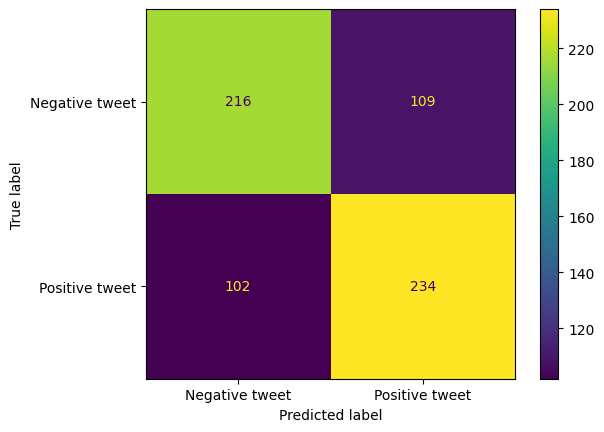

In [29]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative tweet", "Positive tweet"])
disp.plot()